# Analyse du marché de l'emploi au Cameroun

## I. Importation des bibliothèques, fichier excel et traduction

In [1]:
# Importation des bibliothèques
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from deep_translator import GoogleTranslator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Importation du fichier csv
df = pd.read_excel ("emplois_prenettoyé.xlsx")
df

,Date de publication,Date limite,Localisation,Titre du poste,Entreprise,Secteur d'activité,Type de contrat,Formation,Expérience,Compétences
0,2024-06-15 00:00:00,30/06/2024,Yaoundé,Delivery Officer,Kaeyros Analytics,Informatique,CDI,BTS en Informatique,0.0,NaN
1,2024-06-09 00:00:00,24/06/2024,Cameroun,COMMERCIAL,Prudential Beneficial,"Administration, Comptabilité, Vente,Gestion",CDD,Bac,0.0,Offre disponible aux personnes majeures
2,2024-06-19 17:00:00,04/07/2024 17:00,Douala,PERSONAL ASSISTANT - EXECUTIVE,Teja Farm,"Administration, Comptabilité, Vente,Gestion",CDI,BTS en Gestion,5.0,NaN
3,2024-06-19 00:00:00,04/07/2024,Douala,Commercial H/F,Areko Group,"Administration, Comptabilité, Vente,Gestion",CDI,Bac ou une formation professionnelle en Commer...,2.0,; Excellentes qualités relationnelles et capac...
4,2024-07-07 00:00:00,22/07/2024,Douala,COMMERCIAL,Proximity Care Sarl,"Administration, Comptabilité, Vente,Gestion",CDI,"BTS en Action Commerciale, Marketing, commerce...",2.0,·; Avoir une expérience minimum de dans le do...
...,...,...,...,...,...,...,...,...,...,...
1128,2024-06-19 00:00:00,2024-06-29 00:00:00,Yaoundé,Stagiaire Support Technique Applicatif - Yaoundé,ADVENT SOFT,Services,Stage,BTS,0.0,NaN
1129,2024-06-19 00:00:00,2024-06-29 00:00:00,Yaoundé,Développeur Full Stack Java/Spring/Angular,ADVENT SOFT,Services,CDD,Licence,5.0,"La modélisation, le développement Back-end de..."
1130,2024-06-18 00:00:00,2024-06-28 00:00:00,Cameroun,Commercial - Douala,AMARAL CONSULTING,Services,Freelance,Bac,0.0,. Objectif par semaine : 01 vente minimum.
1131,2024-06-18 00:00:00,2024-06-28 00:00:00,Cameroun,QA Engineer,RODEC,Services,CDI,Licence,5.0,"A detail oriented, organized . Working close..."


In [3]:
# Initialisation du traducteur
translator = GoogleTranslator (source = 'auto', target = 'fr')

In [103]:
# Traduction de la colonne "Compétences" en français
df["Compétences_traduites"] = df["Compétences"].dropna().apply(translator.translate).apply(getattr, args=('text',))

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
# Traduction de la colonne "Titre du poste" en français
df["Titre du poste_traduites"] = df["Titre du poste"].dropna().apply(translator.translate).apply(getattr, args=('text',))

## II. Analyse exploratoire des données

In [5]:
# Exploration des données
df.describe ()

,Expérience
count,1133.000000
mean,2.311342
std,2.496152
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,15.000000


In [6]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date de publication   1133 non-null   object 
 1   Date limite           1133 non-null   object 
 2   Localisation          1133 non-null   object 
 3   Titre du poste        1133 non-null   object 
 4   Entreprise            1133 non-null   object 
 5   Secteur d'activité    1133 non-null   object 
 6   Type de contrat       1133 non-null   object 
 7   Formation             1133 non-null   object 
 8   Expérience            1133 non-null   float64
 9   Compétences           858 non-null    object 
dtypes: float64(1), object(9)
memory usage: 88.6+ KB


In [7]:
df.dtypes

Date de publication      object
Date limite              object
Localisation             object
Titre du poste           object
Entreprise               object
Secteur d'activité       object
Type de contrat          object
Formation                object
Expérience              float64
Compétences              object
dtype: object

In [8]:
# Vérification des valeurs manquantes par colonnes
df.isnull().sum()

Date de publication       0
Date limite               0
Localisation              0
Titre du poste            0
Entreprise                0
Secteur d'activité        0
Type de contrat           0
Formation                 0
Expérience                0
Compétences             275
dtype: int64

In [9]:
# Remplacer les valeurs manquantes de "Compétences"
df["Compétences"].fillna("Aucune", inplace = True)

In [10]:
# Vérification des valeurs manquantes par colonnes
df.isnull().sum()

Date de publication     0
Date limite             0
Localisation            0
Titre du poste          0
Entreprise              0
Secteur d'activité      0
Type de contrat         0
Formation               0
Expérience              0
Compétences             0
dtype: int64

In [11]:
# Vérification des valeurs dupliquées par colonnes
df.duplicated

<bound method DataFrame.duplicated of      Date de publication           Date limite Localisation  \
0     2024-06-15 00:00:00           30/06/2024      Yaoundé   
1     2024-06-09 00:00:00           24/06/2024     Cameroun   
2     2024-06-19 17:00:00     04/07/2024 17:00       Douala   
3     2024-06-19 00:00:00           04/07/2024       Douala   
4     2024-07-07 00:00:00           22/07/2024       Douala   
...                   ...                  ...          ...   
1128  2024-06-19 00:00:00  2024-06-29 00:00:00      Yaoundé   
1129  2024-06-19 00:00:00  2024-06-29 00:00:00      Yaoundé   
1130  2024-06-18 00:00:00  2024-06-28 00:00:00     Cameroun   
1131  2024-06-18 00:00:00  2024-06-28 00:00:00     Cameroun   
1132  2024-06-18 00:00:00  2024-06-28 00:00:00     Cameroun   

                                        Titre du poste  \
0                                     Delivery Officer   
1                                           COMMERCIAL   
2                       PERSONA

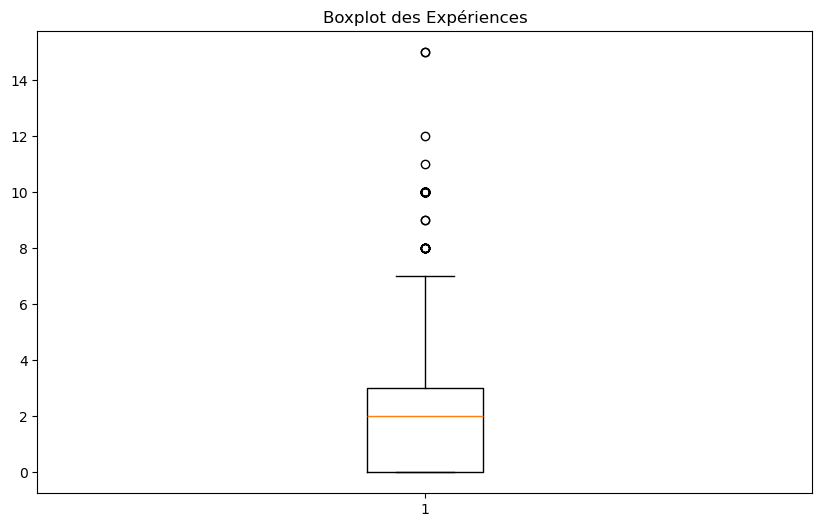

les valeurs aberrantes des expériences sont :      Date de publication        Date limite  Localisation  \
26    2024-06-08 17:00:00  23/06/2024 17:00       Yaoundé   
32    2024-06-05 23:59:00  20/06/2024 23:59       Yaoundé   
69    2024-05-31 17:00:00  15/06/2024 17:00      Cameroun   
83    2024-06-04 17:00:00  19/06/2024 17:00       Yaoundé   
98    2024-05-26 17:00:00  10/06/2024 17:00        Douala   
110   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
111   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
112   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
113   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
114   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
115   2024-05-15 17:00:00  30/05/2024 17:00      Cameroun   
116   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
148   2024-05-15 17:00:00  30/05/2024 17:00        Douala   
185   2024-05-15 17:00:00  30/05/2024 17:00       Yaoundé   
187   2024-05-08 17:00:00  23/05/2024 1

In [12]:
# Vérification de valeurs aberrantes par colonnes
# Colonne des expériences
plt.figure (figsize = (10,6))
plt.boxplot(df['Expérience'])
plt.title("Boxplot des Expériences")
plt.show ()
Q1 = df["Expérience"].quantile(0.25)
Q3 = df["Expérience"].quantile(0.75)
IQR = Q3 - Q1
seuil_inf = Q1 - 1.5*IQR
seuil_sup = Q3 + 1.5*IQR
valeurs_aberrantes_experiences = df[(df["Expérience"]< seuil_inf)|(df["Expérience"]> seuil_sup)]
print ("les valeurs aberrantes des expériences sont :", valeurs_aberrantes_experiences)

In [13]:
seuil_inf = Q1 - 1.5*IQR
seuil_inf

-4.5

In [14]:
seuil_sup = Q3 + 1.5*IQR
seuil_sup

7.5

## III. Evaluation des quantités d'offres par année, par secteur d'activité, par localité, par type de contrat et par entreprise

In [15]:
# Calcul de la somme des offres par catégories
Offres_Catégories = df.groupby("Secteur d'activité")[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending = False)
Offres_Catégories.head(15)

,Titre du poste
Secteur d'activité,
"Administration, Comptabilité, Vente,Gestion",220
Finance,118
Services,103
Informatique,93
Marketing,91
Logistique,58
Santé,42
Science Sociale,40
Environnement,40


In [16]:
# Calcul de la somme des offres par localisation
Offres_Localisation = df.groupby("Localisation")[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending = False)
Offres_Localisation.head(10)

,Titre du poste
Localisation,
Douala,419
Yaoundé,351
Cameroun,154
Maroua,32
"Douala, Yaoundé",31
Kousseri,12
Bertoua,11
Dschang,10
bafoussam,9


In [17]:
# Calcul de la somme des offres par type de contrat
Offres_contrat = df.groupby("Type de contrat")[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending = False)
Offres_contrat

,Titre du poste
Type de contrat,
CDI,737
CDD,334
Stage,60
Freelance,2


In [18]:
# Calcul de la somme des offres par entreprises
Offres_Entreprise = df.groupby("Entreprise")[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending = False)
Offres_Entreprise.head(10)

,Titre du poste
Entreprise,
Petites et Moyennes Entreprises (PME),71
MTN,35
GIZ,22
HSD,20
Africa Food Distribution,20
APAVE,17
UCB,17
Areko Group,16
5G SOLUTION AND SERVICE SARL,15


In [20]:
# Calcul de la somme des offres par entreprises et secteur d'activité
Offres_Entreprise_secteuractivité = df.groupby(["Entreprise","Secteur d'activité"])[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending = False)
Offres_Entreprise_secteuractivité.head(10)

Titre du poste
Entreprise                            Secteur d'activité                                         
Petites et Moyennes Entreprises (PME) Administration, Comptabilité, Vente,Gestion              26
                                      Services                                                 17
Areko Group                           Administration, Comptabilité, Vente,Gestion               8
2beinTech                             Informatique                                              8
APAVE                                 Finance                                                   7
Kaeyros Analytics                     Informatique                                              7
MTN                                   Administration, Comptabilité, Vente,Gestion               7
WWF                                   Environnement                                             6
GIZ                                   Finance                                                   6
MTN                                   Marketing                                                 6

## IV. Graphiques des quantités d'offres par secteur d'activité, par localité, par type de contrat et par entreprise

In [ ]:

Offres_Catégories.head(10).plot(kind ="bar",figsize = (10,8),color = "skyblue", title ="Offres d\'emplois par secteur d\'activité")
plot.xlabel('Secteur d\'activités')
plot.ylabel('Nombre d\'offres')
plt.show ()

In [ ]:

fig = px.bar(Offres_Catégories.head(10),x ='Titre du poste', y = 'Secteur d\'activité',color = "skyblue", title ="Offres d\'emplois par secteur d\'activités")
fig.show()

# V. Traitement du langage naturel pour la prédiction

In [89]:
# Initialiser le lemmatizer et les stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('french','english'))

# Fonction de prétraitement
def preprocess_text(text):
    text = text.lower()  # Convertir en minuscules
    text = ''.join([char for char in text if char not in stop_words])  # Supprimer la ponctuation
    words = text.split()  # Diviser en mots
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatisation et suppression des stopwords
    return ' '.join(words)

In [90]:
# Appliquer le prétraitement aux Compétences
df["Compétences"] = df["Compétences"].apply(preprocess_text)

In [112]:
df["Compétences"].head()

0                                                 auue
1                             offre ipoibe peroe aeure
2                                                 auue
3    ; exeee quaié reaioee e apaié ovaire;', '·; bo...
4    ·; avoir ue expériee iiu e a e oaie;;', '·; bo...
Name: Compétences, dtype: object

In [91]:
# Appliquer le prétraitement aux Diplômes
df["Formation"] = df["Formation"].apply(preprocess_text)

In [92]:
categories = [["Administration, Comptabilité, Vente,Gestion","Finance","Services","Informatique","Marketing","Logistique","Santé","Environnement","Science Sociale","Humanitaire","RH","Communication","Industrie","Audit","Télécommunications","Tous les Profils","Agronomie","Droit","Electricité","Economie","Mécanique","BTP","Enseignement","Assurance","Agro-Alimentaire","Biochimie","Comptabilité","Mathématiques","sécurité","Electronique","Froid et Climatisation","Projet","Chimie","Hydraulique","Electromécanique","Biologie","Transport","Sciences Politiques","Plomberie","Pharmacie","Foresterie"]]

In [126]:
# Encodage de la colonne "Secteur d'activité"
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder ()
df["Secteur d'activité_encoded"]= encoder.fit_transform(df[["Secteur d'activité"]])
df["Secteur d'activité_encoded"]

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0       24
1        0
2        0
3        0
4        0
        ..
1128    36
1129    36
1130    36
1131    36
1132    36
Name: Secteur d'activité_encoded, Length: 1133, dtype: int32

In [127]:
# Subdivision des données
X = df['Compétences']
y = df['Secteur d\'activité_encoded']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) 

In [128]:
# Vectorisation des commentaires
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [129]:
from sklearn.linear_model import LogisticRegression

In [130]:
# Construction des modeles
modelLR =LogisticRegression()
modelNB = MultinomialNB()
model_knn = KNeighborsClassifier()
model_svm=SVC(kernel='linear')

In [131]:
modelLR.fit(X_train_vect, y_train)
modelNB.fit(X_train_vect, y_train)
model_knn.fit(X_train_vect, y_train)
model_svm.fit(X_train_vect, y_train)

SVC(kernel='linear')

In [132]:
# Prédictions
y_predLR = modelLR.predict(X_test_vect)
y_predNB = modelNB.predict(X_test_vect)
y_predKNN = model_knn.predict(X_test_vect)
y_predSVM = model_svm.predict(X_test_vect)

In [133]:
# Matrice de confusion
conf_matrixLR = confusion_matrix(y_test, y_predLR)
conf_matrixNB = confusion_matrix(y_test, y_predNB)
conf_matrixKNN= confusion_matrix(y_test, y_predKNN)
conf_matrixSVM= confusion_matrix(y_test, y_predSVM)

print("Matrice de confusion pour LR :\n", conf_matrixLR)
print("Matrice de confusion pour NB :\n", conf_matrixNB)
print("Matrice de confusion pour KNN :\n", conf_matrixKNN)
print("Matrice de confusion pour SVM :\n", conf_matrixSVM)

Matrice de confusion pour LR :
 [[35  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]
 ...
 [ 1  0  0 ...  0  0  0]
 [ 4  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]]
Matrice de confusion pour NB :
 [[43  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 [ 3  0  0 ...  0  0  0]
 ...
 [ 1  0  0 ...  0  0  0]
 [ 5  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]]
Matrice de confusion pour KNN :
 [[23  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 [ 1  0  1 ...  0  0  0]
 ...
 [ 1  0  0 ...  0  0  0]
 [ 4  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]]
Matrice de confusion pour SVM :
 [[34  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]
 ...
 [ 1  0  0 ...  0  0  0]
 [ 4  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]]


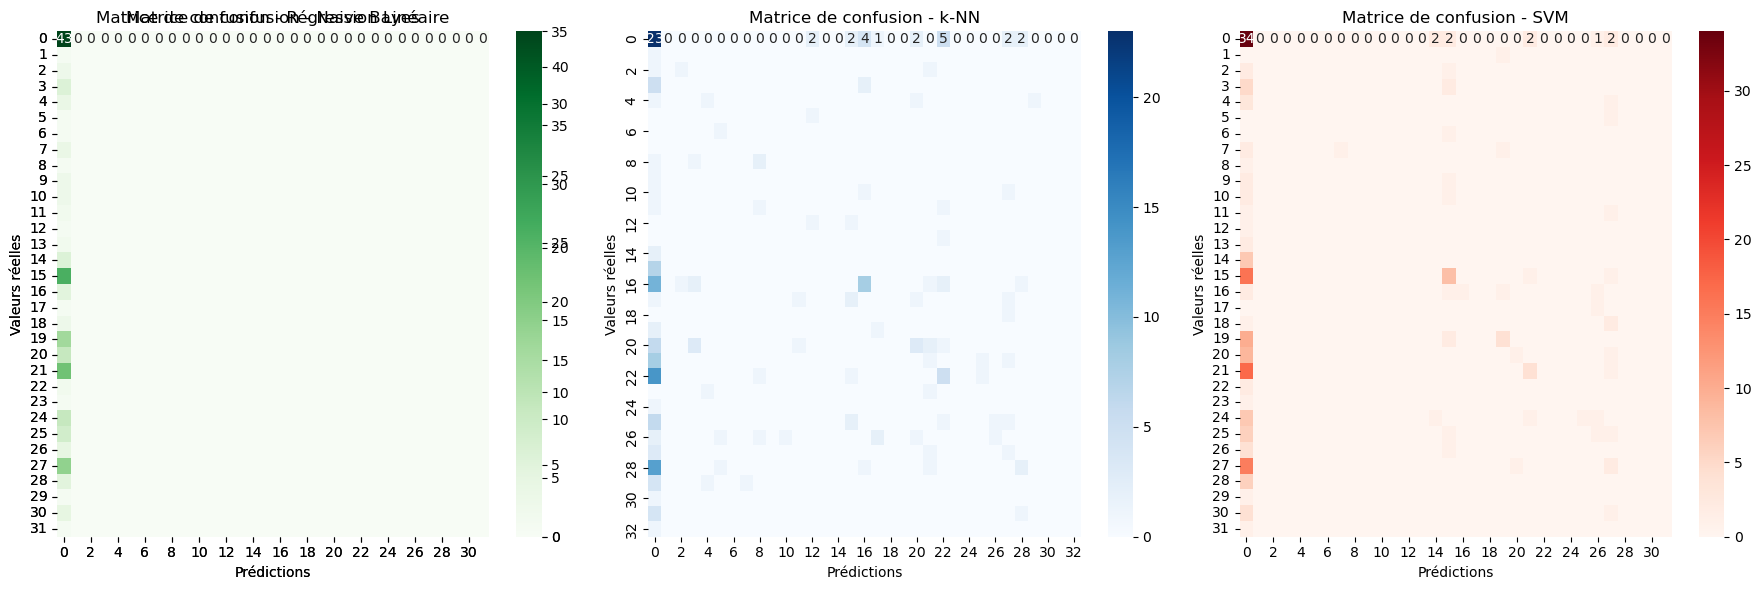

In [134]:
# Génération des graphiques
plt.figure(figsize=(18, 6))

# Matrice de confusion pour la Régression Linéaire
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrixLR, annot=True, cmap="Greens")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion - Régression Linéaire')

# Matrice de confusion pour Naive Bayes
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrixNB, annot=True, cmap="Greens")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion - Naive Bayes')

# Matrice de confusion pour k-NN
plt.subplot(1, 3, 2)
sns.heatmap(conf_matrixKNN, annot=True, cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion - k-NN')

# Matrice de confusion pour SVM
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrixSVM, annot=True, cmap="Reds")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion - SVM')

# Affichage des graphiques
plt.tight_layout()
plt.savefig('matrices_confusion.png')
plt.show()

In [135]:
# Calcul des rapports de classification pour chaque modèle
reportLR = classification_report(y_test, y_predLR, output_dict=True)
reportNB = classification_report(y_test, y_predNB, output_dict=True)
reportKNN = classification_report(y_test, y_predKNN, output_dict=True)
reportSVM = classification_report(y_test, y_predSVM, output_dict=True)

# Création des DataFrames à partir des rapports de classification
df_report = pd.DataFrame({
    'Modèle': ['LogisticRegression','Naive Bayes', 'k-NN', 'SVM'],
    'Précision': [reportLR['weighted avg']['precision'],reportNB['weighted avg']['precision'], reportKNN['weighted avg']['precision'], reportSVM['weighted avg']['precision']],
    'Rappel': [reportLR['weighted avg']['recall'],reportNB['weighted avg']['recall'], reportKNN['weighted avg']['recall'], reportSVM['weighted avg']['recall']],
    'F1-score': [reportLR['weighted avg']['f1-score'],reportNB['weighted avg']['f1-score'], reportKNN['weighted avg']['f1-score'], reportSVM['weighted avg']['f1-score']]
})
df_report

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classif

,Modèle,Précision,Rappel,F1-score
0,LogisticRegression,0.163322,0.215859,0.137792
1,Naive Bayes,0.035883,0.189427,0.060336
2,k-NN,0.226792,0.215859,0.189894
3,SVM,0.251250,0.242291,0.183547


## V. Optimisation des modèles utilisés

In [147]:
from sklearn.preprocessing import MaxAbsScaler

In [148]:
# Normalisation des données
scaler = MaxAbsScaler ()
X_train_nor= scaler.fit_transform(X_train_vect)
X_test_nor= scaler.fit_transform(X_test_vect)

### 1. Random Search

In [149]:
# Importation de l'algorithme
from sklearn.model_selection import RandomizedSearchCV

In [150]:
# Définition de la distribution des hyperparamètres à tester
from scipy.stats import randint
param_dist = {
    'n_neighbors':randint(1,40),
    'metric':['euclidean','manhattan','chebyshev']
}

In [151]:
# Configuration de Random Search
Random_search = RandomizedSearchCV (model_knn,param_dist, n_iter = 50, cv = 5, random_state = 42)

In [154]:
# Entrainement du modèle avec Random Search
Random_search.fit(X_train_nor,y_train)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=50,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000177B672A090>},
                   random_state=42)

In [155]:
# Affichage des meilleurs paramètres
print ("Meilleurs paramètres (Random Search):", Random_search.best_params_)

Meilleurs paramètres (Random Search): {'metric': 'euclidean', 'n_neighbors': 5}


In [156]:
# Evaluation du modèle
y_pred = Random_search.fit(X_test_nor)
accuracy_random = accuracy_score(y_test, y_pred)
print ("Précision(Random Search):",accuracy_random)

ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 684, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: KNeighborsClassifier.fit() missing 1 required positional argument: 'y'


### 2.Grid search

In [ ]:
# Importation de l'algorithme
from sklearn.model_selection import GridSearchCV

In [ ]:
# Définition de la grille des hyperparamètres du modèle
param_grid = {
    'n_neighbors':[3,5,7,9,11,13,15,17,19,21,23,25],
    'metric':['euclidean','manhattan']
}

In [ ]:
# Configuration de Grid Search
grid_search = GridSearchCV (model_knn,param_grid, cv =5)

In [ ]:
# Entrainement du modèle avec Grid Search
grid_search.fit(X_train_nor,y_train)

In [ ]:
# Affichage des meilleurs paramètres
print ("Meilleurs paramètres (Grid Search):", grid_search.best_params_)

In [ ]:
# Evaluation du modèle
y_pred = grid_search.predict(X_test_nor)
accuracy_grid = accuracy_score(y_test, y_pred)
print ("Précision(Grid Search):",accuracy_grid)